Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.
Заказчику важны:

 - качество предсказания;
 - скорость предсказания;
 - время обучения.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import math
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.datasets import make_spd_matrix

from joblib import dump
pd.options.mode.chained_assignment = None

ModuleNotFoundError: No module named 'lightgbm'

In [99]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('/content/autos.csv')

pd.set_option('display.max_columns', None)

In [100]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [101]:
df.columns = df.columns.str.lower()

In [102]:
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [103]:
df = df.rename(columns={'datecrawled':'date_crawled', 'vehicletype':'vehicle_type', 'registrationyear':'registration_year', 'registrationmonth':'registration_month', 'fueltype':'fuel_type', 'notrepaired':'not_repaired', 'datecreated':'date_created', 'numberofpictures':'number_of_pic', 'postalcode':'postal_code', 'lastseen':'last_seen'})

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pic       354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

*Признаки:*

 - Date_crawled — дата скачивания анкеты из базы
 - Vehicle_Type — тип автомобильного кузова
 - Registration_Year — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - Registration_Month — месяц регистрации автомобиля
 - Fuel_Type — тип топлива
 - Brand — марка автомобиля
 - Not_Repaired — была машина в ремонте или нет
 - Date_Created — дата создания анкеты
 - Number_Of_Pictures — количество фотографий автомобиля
 - Postal_Code — почтовый индекс владельца анкеты (пользователя)
 - Last_Seen — дата последней активности пользователя

*Целевой признак:*

 - Price — цена (евро)

In [105]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pic,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [106]:
df.corr()

,price,registration_year,power,kilometer,registration_month,number_of_pic,postal_code
price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
registration_year,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
registration_month,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
number_of_pic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Явной корреляции между признаками нет. Но есть анамалии в данных, например максимальный год регистрации равен 9999, есть нули (незаполненные данные), но нет отрицательных значений. Много колонок "object", в том числе с датами и пока не ясно на сколько они нам нужны.

In [107]:
df.duplicated().sum()

4

In [108]:
df = df.drop_duplicates().reset_index(drop=True)

In [109]:
df.duplicated().sum()

0

Были удалены 4 явных дубликата.

Посмотрим значения в столбцах и пропуски:

In [110]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pic             0
postal_code               0
last_seen                 0
dtype: int64

In [111]:
(df.isna().mean())*100

date_crawled           0.000000
price                  0.000000
vehicle_type          10.579487
registration_year      0.000000
gearbox                5.596772
power                  0.000000
model                  5.560651
kilometer              0.000000
registration_month     0.000000
fuel_type              9.282802
brand                  0.000000
not_repaired          20.079297
date_created           0.000000
number_of_pic          0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

In [112]:
df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [113]:
df['vehicle_type'] = df['vehicle_type'].fillna(value='other')

In [114]:
df['vehicle_type'].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

В столбце 'vehicle_type' пропуски были заменены на "other".

In [115]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Пропусков 5,6%, поэтому принято решение удалить эти данные.

In [116]:
df = df.dropna(subset = ['gearbox'], axis = 0)

In [117]:
df['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

In [118]:
df['power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,   136,   160,   231,    90,
         118,   193,    99,    60,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,   165,    98,    41,
         130,   114,   211,    56,   201,   213,    58,   107,   174,
         100,   220,    85,    73,   192,    68,    66,    74,    52,
         147,    65,   310,    71,    97,   239,   203,     5,   300,
         103,   258,   320,    63,    81,   148,    44,    83,   145,
         230,   280,   260,   104,   299,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

In [119]:
df = df.drop(df[df['power'] == 0].index)

In [120]:
df = df.drop(df[df['power'] > 1500].index)

In [121]:
df.groupby('power')['power'].count().sort_values(ascending=False)

power
75     23354
60     15422
150    14348
101    13034
140    12691
       ...  
640        1
612        1
610        1
332        1
550        1
Name: power, Length: 551, dtype: int64

In [122]:
df.shape

(307426, 16)

Так же были удалены данные где мощность равна нулю и больше 1500 л.с. считаю, что данные такого типа очень важны для оценки стоимости автомобиля. Ведь это сердце любой машины :) не может быть нуля, а по поводу максимума гугл выдает что то в районе 1400 л.с. поэтому удалила все, что больше 1500

In [123]:
df['model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'astra', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', '156', 'escort', 'forester', 'xc_reihe', 'scenic',
       'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo', 'slk',
       '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sportage',
       'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia',
       'ka', 'almera', 'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo',
       'cordoba', 'colt', 'impreza', 'vectra', 'berlingo', 'tiguan',
       'i_reihe', '6_reihe', 'panda', 'up', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider'

In [124]:
df['model'] = df['model'].fillna(value='other')

In [125]:
df['model'].unique()

array(['other', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er', 'b_klasse',
       'a8', 'jetta', 'astra', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', '156', 'escort', 'forester', 'xc_reihe', 'scenic',
       'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega', 'polo', 'slk',
       '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sportage',
       'sorento', 'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia',
       'ka', 'almera', 'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo',
       'cordoba', 'colt', 'impreza', 'vectra', 'berlingo', 'tiguan',
       'i_reihe', '6_reihe', 'panda', 'up', 'ceed', 'kangoo', '5_reihe',
       'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus',
       'fox', 'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider',
   

In [126]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [127]:
df['fuel_type'] = df['fuel_type'].fillna(value='other')

In [128]:
df['fuel_type'].unique()

array(['gasoline', 'petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

В столбцах с моделями и типом топлива пустые строки были заменены на 'other' (по аналогии, т.к. в этих столбцах уже есть такие данные).

In [129]:
df['registration_month'].unique()

array([ 5,  8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  9])

In [130]:
df[df['registration_month'] == 0].count()

date_crawled          19878
price                 19878
vehicle_type          19878
registration_year     19878
gearbox               19878
power                 19878
model                 19878
kilometer             19878
registration_month    19878
fuel_type             19878
brand                 19878
not_repaired          10521
date_created          19878
number_of_pic         19878
postal_code           19878
last_seen             19878
dtype: int64

In [133]:
df = df.dropna(subset = ['registration_month'], axis = 0)

Выбор был между тем что бы удалить данные с нулями или в принципе удалить данный столбец, т.к. мне почему то кажется что важен год регистрации автомобиля (постановка на учет) что бы понимать на сколько он старый. А месяц наверное не важно. И спросить не у кого, начальника нет :) Жду комментариев ревьюера по данному вопросу. Я пока удалила строки с нулями.

In [134]:
df['not_repaired'].unique()

array(['yes', nan, 'no'], dtype=object)

In [135]:
df.groupby('not_repaired')['not_repaired'].count().sort_values(ascending=False)

not_repaired
no     230375
yes     30586
Name: not_repaired, dtype: int64

Так как угадать нельзя была ли машина в ремонте, поэтому решила эти данные удалить.

In [136]:
df = df.dropna(subset = ['not_repaired'], axis = 0)

При вызове discribe в столбце с количеством картинок везде были нули. проверим этот столбец.

In [137]:
df['number_of_pic'].unique()

array([0])

In [138]:
df = df.drop(columns = ['number_of_pic'],axis = 1)

Столбец содержит только нули, поэтому удаляем!

In [139]:
df.shape

(260961, 15)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260961 entries, 1 to 354363
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        260961 non-null  object
 1   price               260961 non-null  int64 
 2   vehicle_type        260961 non-null  object
 3   registration_year   260961 non-null  int64 
 4   gearbox             260961 non-null  object
 5   power               260961 non-null  int64 
 6   model               260961 non-null  object
 7   kilometer           260961 non-null  int64 
 8   registration_month  260961 non-null  int64 
 9   fuel_type           260961 non-null  object
 10  brand               260961 non-null  object
 11  not_repaired        260961 non-null  object
 12  date_created        260961 non-null  object
 13  postal_code         260961 non-null  int64 
 14  last_seen           260961 non-null  object
dtypes: int64(6), object(9)
memory usage: 31.9+ MB


Посмотрим что с пропусками в итоге:


In [141]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
postal_code           0
last_seen             0
dtype: int64

Пропусков нет! И данных достаточно для обучения!

Теперь ниже изучим даты и подумаем, что с ними можно сделать.

In [142]:
df[['date_crawled', 'date_created']].head(50)

,date_crawled,date_created
1,2016-03-24 10:58:45,2016-03-24 00:00:00
3,2016-03-17 16:54:04,2016-03-17 00:00:00
4,2016-03-31 17:25:20,2016-03-31 00:00:00
5,2016-04-04 17:36:23,2016-04-04 00:00:00
6,2016-04-01 20:48:51,2016-04-01 00:00:00
7,2016-03-21 18:54:38,2016-03-21 00:00:00
10,2016-03-26 19:54:18,2016-03-26 00:00:00
11,2016-04-07 10:06:22,2016-04-07 00:00:00
13,2016-03-21 21:37:40,2016-03-21 00:00:00
14,2016-03-21 12:57:01,2016-03-21 00:00:00


Столбцы совпадают по дате, посмотрела с разны сторон, плюс не думаю, что дата скачивания в принципе важна, поэтому решила один столбец удалить.

In [143]:
df = df.drop(columns = ['date_crawled'],axis = 1)

In [144]:
df.shape

(260961, 14)

Второй столбец переведем в дату и уже получим новые столбцы с месяцами и годами создания. Возможно , активность рынка в разные месяцы и года имеют значения для ценообразования, так как люди размещают обьявления в определенные сезоны, события и пр... Активность и спады имеют место быть. 

In [145]:
df.head(2)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17


In [146]:
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d %H:%M:%S')

In [147]:
df['month_created'] = pd.DatetimeIndex(df['date_created']).month
df['year_created'] = pd.DatetimeIndex(df['date_created']).year

In [148]:
df['month_created'].unique()

array([ 3,  4,  2,  1, 11, 12,  9,  8])

In [149]:
df['year_created'].unique()

array([2016, 2015])

In [150]:
df = df.drop(columns = ['date_created'],axis = 1)

Думаю колонка с последним визитом так же не имеет значения, т.к. это не дает информацию о том продали ли автомобиль, или все таки нет. Наврядли это как то влияет на ценообразование.

In [151]:
df = df.drop(columns = ['last_seen'],axis = 1)

Познакомимся с данными в столбце с датой регистрации автомобиля.

In [152]:
df['registration_year'].sort_values().unique()

array([1000, 1910, 1923, 1929, 1930, 1931, 1932, 1935, 1937, 1938, 1940,
       1941, 1942, 1943, 1944, 1945, 1947, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 4000,
       5000, 6000, 6500, 9000])

Думаю, надо удалить даты до 1970 года (слишкос старые, и количество их оч мало) и после 2016 года (так как скачивание было в 2016 году, поэтому не понятно, как туда попали данные за 2017 год и старше).

In [153]:
(df[df['registration_year'] <= 1970].count())/len(df['registration_year'])

price                 0.002537
vehicle_type          0.002537
registration_year     0.002537
gearbox               0.002537
power                 0.002537
model                 0.002537
kilometer             0.002537
registration_month    0.002537
fuel_type             0.002537
brand                 0.002537
not_repaired          0.002537
postal_code           0.002537
month_created         0.002537
year_created          0.002537
dtype: float64

In [154]:
df = df.drop(df[df['registration_year'] <= 1970].index)

In [155]:
df = df.drop(df[df['registration_year'] >= 2016].index)

In [156]:
df.shape

(250294, 14)

Посмотрим на пробег, прайс и почтовый индекс (оставшиеся столбцы):

In [157]:
df.head(2)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,postal_code,month_created,year_created
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,66954,3,2016
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,3,2016


In [158]:
df['kilometer'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000])

In [159]:
df['postal_code'].sort_values().unique()

array([ 1067,  1068,  1069, ..., 99994, 99996, 99998])

Думаю, что 'postal_code' не имеет значения, поэтому лучше его удалить. Не всегда данный индекс имеет отношения к региону где машина использовалась или продается.

In [160]:
df = df.drop(columns = ['postal_code'],axis = 1)

In [161]:
df[df['price']<10].count()

price                 4127
vehicle_type          4127
registration_year     4127
gearbox               4127
power                 4127
model                 4127
kilometer             4127
registration_month    4127
fuel_type             4127
brand                 4127
not_repaired          4127
month_created         4127
year_created          4127
dtype: int64

С пробегом вроде бы все отлично, с индексами не ясно, но скорее всего все ок, а вот цены местами слишком маленькие. Поэтому данные выбросы лучше удалить.

In [162]:
df = df.drop(df[df['price'] < 100].index)

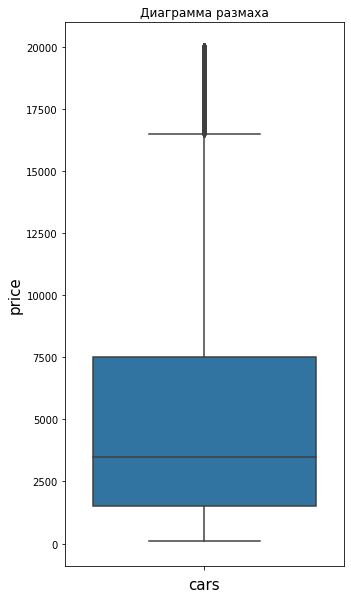

In [163]:
plt.figure(figsize=(5,10))
sns.boxplot(data=df, y='price')
plt.title('Диаграмма размаха')
plt.xlabel('cars', fontsize=15)
plt.ylabel('price', fontsize=15)
plt.show()

Так же удалим цены выше 17тыс. евро как выбросы.

In [164]:
df = df.drop(df[df['price'] > 17000].index)

In [165]:
df['price'].sort_values().unique()

array([  100,   101,   105, ..., 16998, 16999, 17000])

In [166]:
df.shape

(239024, 13)

In [167]:
df.groupby('price')['price'].count() 

price
100      361
101        3
105        1
110       11
111        3
        ... 
16990    177
16995      8
16998      3
16999    224
17000    253
Name: price, Length: 3136, dtype: int64

Посмотрим на общие суммы которые хотят за автомобили выпущенные в разные года (зарегестрированные в разные года).

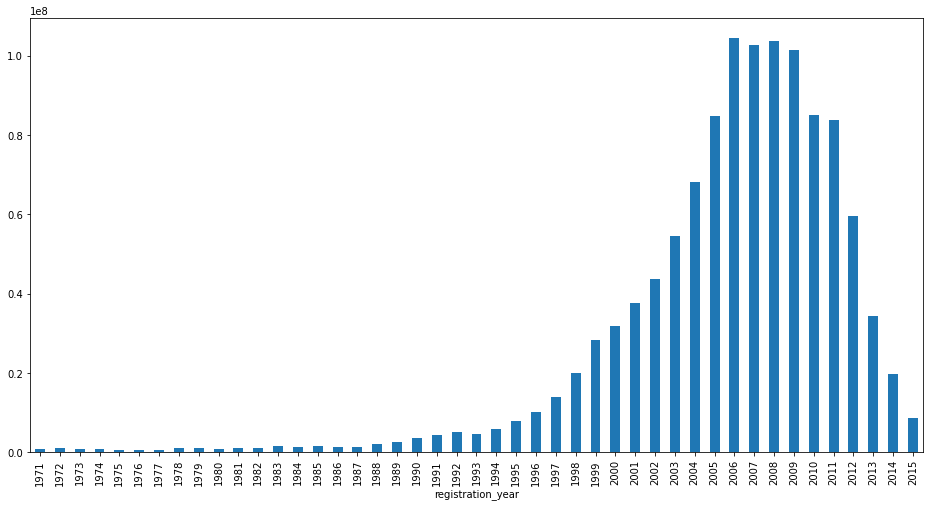

In [168]:
df.groupby('registration_year')['price'].sum().plot(kind='bar', figsize=(16,8))
plt.show()

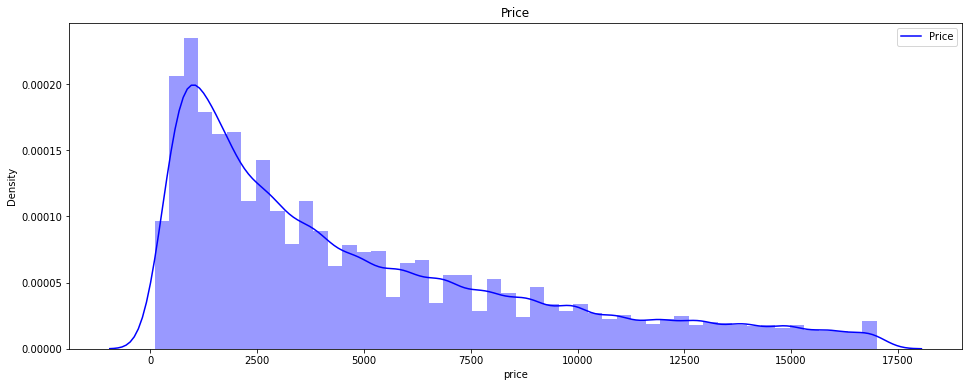

In [169]:
plt.figure(figsize=(16,6))
sns.distplot(df['price'], bins=None, hist=True, color='blue')
plt.legend(['Price'])
plt.title('Price')
plt.show()

In [170]:
df.corr()

,price,registration_year,power,kilometer,registration_month,month_created,year_created
price,1.000000,0.586040,0.457561,-0.370011,0.047931,0.014555,-0.003052
registration_year,0.586040,1.000000,0.121216,-0.363770,0.034865,0.000176,-0.003134
power,0.457561,0.121216,1.000000,0.135959,0.028409,0.001560,-0.000312
kilometer,-0.370011,-0.363770,0.135959,1.000000,-0.009368,-0.001844,0.004564
registration_month,0.047931,0.034865,0.028409,-0.009368,1.000000,-0.002199,0.003250
month_created,0.014555,0.000176,0.001560,-0.001844,-0.002199,1.000000,-0.178764
year_created,-0.003052,-0.003134,-0.000312,0.004564,0.003250,-0.178764,1.000000


## Обучение разных моделей с различными гиперпараметрами.

Возмем две модели: модель градиентного бустинга LightGBM и Случайный лес.

Для начала будет проведена обработка Ordinal Encoder, далее разобьем данные на признаки и целевой признак, а так же поделим на обучающую и тестовую выборки. И в конце масшабирование.

In [171]:
numeric = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
encoder = OrdinalEncoder()
encoder.fit(df[numeric])
df[numeric] = encoder.transform(df[numeric])

In [172]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,month_created,year_created
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0,3,2016
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,3,2016
5,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0,4,2016
6,2200,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0,4,2016
10,2000,4.0,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0,3,2016


In [173]:
df = df.reset_index(drop=True)
df.head(15)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,month_created,year_created
0,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,38.0,0.0,3,2016
1,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,3,2016
2,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0,4,2016
3,2200,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0,4,2016
4,2000,4.0,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0,3,2016
5,2799,7.0,2005,1.0,140,170.0,150000,12,2.0,38.0,1.0,4,2016
6,2500,7.0,2004,1.0,131,170.0,150000,2,5.0,38.0,0.0,3,2016
7,1750,5.0,2004,0.0,75,226.0,150000,2,6.0,27.0,0.0,3,2016
8,7550,0.0,2007,1.0,136,60.0,150000,6,2.0,10.0,0.0,3,2016
9,1850,0.0,2004,1.0,102,33.0,150000,1,6.0,20.0,0.0,4,2016


In [174]:
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
month_created         0
year_created          0
dtype: int64

In [175]:
df.shape

(239024, 13)

In [176]:
features = df.drop(['price'], axis=1)
target = df['price']

In [177]:
features_train, features_test, target_train, target_test = train_test_split(
                       features, target, test_size=0.25, random_state=12345)

In [178]:
print(
features_train.shape,
target_train.shape,
features_test.shape,
target_test.shape
)

(179268, 12) (179268,) (59756, 12) (59756,)


In [179]:
numeric_col = ['registration_year', 'power', 'kilometer', 'year_created']
scaler = StandardScaler()
scaler.fit(features_train[numeric_col])
features_train[numeric_col] = scaler.transform(features_train[numeric_col])
features_test[numeric_col] = scaler.transform(features_test[numeric_col])

In [180]:
features_train.isna().sum()

vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
month_created         0
year_created          0
dtype: int64

In [181]:
print(
features_train.shape,
target_train.shape,
features_test.shape,
target_test.shape
)

(179268, 12) (179268,) (59756, 12) (59756,)


### Случайный лес

Данные готовы для обучения! Начнем со Случайного Леса.
Для подбора лучших параметров воспользуемся GridSearchCV.



In [182]:
clf = RandomForestRegressor()
grid_parametrs = { 'n_estimators': range (10, 61, 15),
              'max_depth': range (0, 91, 30) }
grid = GridSearchCV(clf, grid_parametrs, cv=5, scoring='neg_root_mean_squared_error')

In [ ]:
grid.fit(features_train, target_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_score_

Теперь можно применить лучшие параметры {'max_depth': 90, 'n_estimators': 55, grid.best_score_ = -1468.937502869905}:

In [ ]:
model = RandomForestRegressor(n_estimators=55, max_depth=90, random_state=12345)
start_time = time.time()
model.fit(features_train, target_train)
lirning_time = time.time() - start_time
print('lirning_time:', lirning_time)

In [ ]:
scores = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_squared_error', cv = 5)

In [ ]:
scores_mean = (scores.mean())

In [ ]:
print('Средняя scores:', (scores_mean)**0.5)

In [ ]:
start_time = time.time()
predictions = model.predict(features_test)
lirning_time = time.time() - start_time
print('lirning_time:', lirning_time)
rmse = math.sqrt(mean_squared_error(target_test, predictions))
print('rmse:', rmse)

Результаты:

Время обучения 28.27 секунд, время предсказания 1.67. rmse = 1453

### Модель градиентного бустинга LightGBM

In [ ]:
lgbm_model = LGBMRegressor(num_leaves=55, max_depth=90, random_state=12345)
start_time = time.time()
lgbm_model.fit(features_train, target_train)
lirning_time = time.time() - start_time
print('lirning_time:', lirning_time)

In [ ]:
scores = cross_val_score(lgbm_model, features_train, target_train, scoring = 'neg_mean_squared_error', cv = 5)

In [ ]:
scores_mean = abs(scores.mean()) ** 0.5
print('Средняя scores:', scores_mean)

In [ ]:
start_time = time.time()
predictions = lgbm_model.predict(features_test)
lirning_time = time.time() - start_time
print('lirning_time:', lirning_time)
rmse = math.sqrt(mean_squared_error(target_test, predictions))
print('rmse:', rmse)

Результаты:

Время обучения 199.56 секунд, время предсказания 0.5. rmse = 1489

## Вывод

Лучший результат у Случайного леса. Лучшее время обучения тоже. Предсказания очень быстро выполнились там и там, не критично. Но это результаты на платформе Яндекса.  На сайте Гугл Колаб результаты по времени наоборот лучше у LightGBM, время обучение около 2 секунд, а у леса 42 секунды. Но rmse все равно лучше у Случайного Леса там и там.